In [56]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm
import nibabel as nib
from nilearn import plotting, datasets, image
from scipy.stats import skew, kurtosis, norm
from scipy import ndimage
import pandas as pd

In [23]:
results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()
print(results.keys())

dict_keys(['HRFindex', 'HRFindexrun', 'glmbadness', 'pcvoxels', 'pcnum', 'xvaltrend', 'noisepool', 'pcregressors', 'betasmd', 'R2', 'R2run', 'rrbadness', 'FRACvalue', 'scaleoffset', 'meanvol'])


In [34]:
betasmd = results['betasmd'][:,:,:,0:90]

X, Y, Z, T = betasmd.shape
V = X * Y * Z
print(f"Number of total voxels {V}")
B = betasmd.reshape(V, T)

n = np.sum(~np.isnan(B), axis=1) # number of valid (non-NaN) trials for each voxel

mu = np.nanmean(B, axis=1) # mean beta across valid trials for each voxel
sd = np.nanstd(B, axis=1, ddof=1) # std dev of beta across valid trials for each voxel
se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat

mu_vol = mu.reshape(X, Y, Z)
sd_vol = sd.reshape(X, Y, Z)
n_vol  = n.reshape(X, Y, Z)
t_vol  = t.reshape(X, Y, Z)

R2 = results['R2run'][:,:,:,0]

t_thr = 3
R2_thr = 1.5

base = (R2 > R2_thr) & (np.abs(t_vol) > t_thr)
print(f"Number of Active voxels {np.sum(base)}")

mask_pos = base & (mu_vol > 0)
print(f"Number of Positively Active voxels {np.sum(mask_pos)}")
mask_neg = base & (mu_vol < 0)
print(f"Number of Negatively Active voxels {np.sum(mask_neg)}")

Number of total voxels 979200


/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/3375456871.py:10: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(B, axis=1) # mean beta across valid trials for each voxel


Number of Active voxels 87656
Number of Positively Active voxels 56926
Number of Negatively Active voxels 30730


/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/.venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/3375456871.py:12: RuntimeWarning: divide by zero encountered in divide
  se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/3375456871.py:12: RuntimeWarning: invalid value encountered in divide
  se = sd / np.sqrt(np.clip(n, 1, None)); t = mu / se  #t-stat


In [41]:
betasmd = results['betasmd']
mask_union = mask_pos | mask_neg
beta_pos = betasmd[mask_union,:]
# print(beta_pos.shape) #(87656, 180)

beta_pos1 = beta_pos[:,:90]
beta_pos2 = beta_pos[:,90:]

beta_diff1 = np.diff(beta_pos1, axis=1)
beta_diff2 = np.diff(beta_pos2, axis=1)

sk1 = skew(beta_diff1, axis=1, bias=False)
kt1 = kurtosis(beta_diff1, axis=1, fisher=False, bias=False)
sk2 = skew(beta_diff2, axis=1, bias=False)
kt2 = kurtosis(beta_diff2, axis=1, fisher=False, bias=False)

sk_thr = 0.1                        # |sk| < 0.1 → near-symmetric
kt_thr = 0.2                        # |kt-3| < 0.2 → near-Normal kurtosis

# voxels meeting both criteria
mask_gaussian_like = (np.abs(sk1) < sk_thr) & (np.abs(kt1 - 3) < kt_thr)
selected_voxels_run1 = np.zeros(mask_pos.shape, dtype=bool)
selected_voxels_run1[mask_union] = mask_gaussian_like
print(selected_voxels_run1.shape)

mask_gaussian_like = (np.abs(sk2) < sk_thr) & (np.abs(kt2 - 3) < kt_thr)
selected_voxels_run2 = np.zeros(mask_pos.shape, dtype=bool)
selected_voxels_run2[mask_union] = mask_gaussian_like
print(selected_voxels_run2.shape)

(90, 128, 85)
(90, 128, 85)


/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1361: RuntimeWarning: invalid value encountered in divide
  nval = ((n - 1.0) * n)**0.5 / (n - 2.0) * m3 / m2**1.5
/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1469: RuntimeWarning: invalid value encountered in divide
  nval = 1.0/(n-2)/(n-3) * ((n**2-1.0)*m4/m2**2.0 - 3*(n-1)**2.0)


In [45]:
def plot_active_voxels_sech(vol, ses, run):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    ax_sag, ax_cor, ax_axial = axes
    fig.suptitle(f"Less Variable Voxles-session {ses}-Run {run}")

    x = vol.shape[0] // 2
    y = vol.shape[1] // 2
    z = vol.shape[2] // 2

    im_sag = ax_sag.imshow(np.rot90(vol[x, :, :]), cmap="gray", origin='lower')
    ax_sag.set_title("Sagittal")
    ax_sag.axis("off")


    im_cor = ax_cor.imshow(np.rot90(vol[:, y, :]), cmap="gray", origin='lower')
    ax_cor.set_title("Coronal")        
    ax_cor.axis("off")

    im_ax = ax_axial.imshow(np.rot90(vol[:, :, z]), cmap="gray", origin='lower')
    ax_axial.set_title("Axial")   
    ax_axial.axis("off")


    def update(i):
        im_sag.set_data(np.rot90(vol[i, :, :]))      # sagittal slices
        im_cor.set_data(np.rot90(vol[:, i, :]))      # coronal slices
        im_ax.set_data(np.rot90(vol[:, :, i]))       # axial slices
        return im_sag, im_cor, im_ax

    ani = FuncAnimation(fig, update, frames=range(min(vol.shape)), interval=100, blit=False)
    fig.tight_layout(rect=[0, 0, 1, 1.5])
    plt.show()

    ani.save(filename=f"selected_voxels_session{ses}_run{run}.gif", writer="pillow")
    return

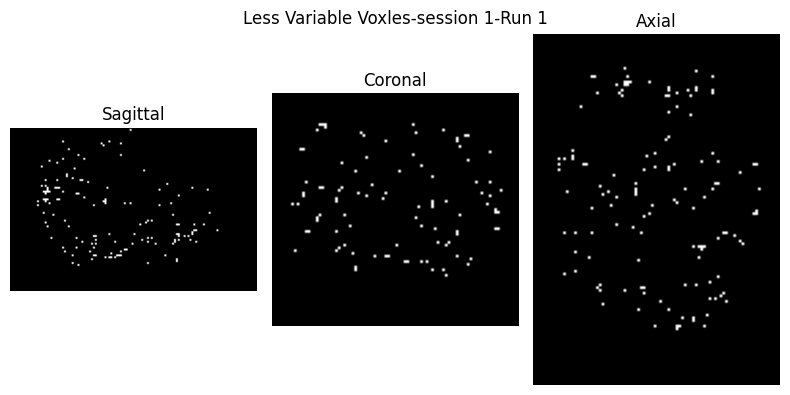

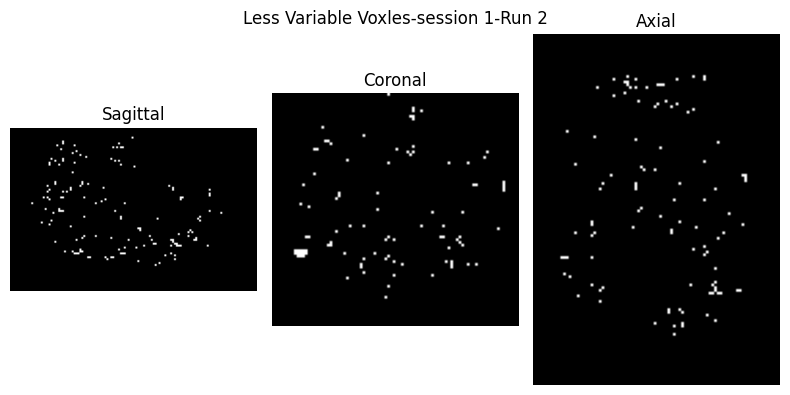

In [46]:
ses = 1
run = 1
plot_active_voxels_sech(selected_voxels_run1, ses, run)

run = 2
plot_active_voxels_sech(selected_voxels_run2, ses, run)

In [48]:
def plot_dist(beta_diff):
    mu    = beta_diff.mean(axis=1)
    sigma = beta_diff.std(axis=1, ddof=1)          # sample std
    sk    = skew(beta_diff, axis=1, bias=False)
    kt    = kurtosis(beta_diff, axis=1, fisher=False, bias=False)

    # Plot a few example rows
    rows_to_show = np.random.choice(beta_diff.shape[0], 5, replace=False)

    fig, axes = plt.subplots(len(rows_to_show), 1, figsize=(6, 2.5*len(rows_to_show)))

    for ax, idx in zip(axes, rows_to_show):
        data = beta_diff[idx]
        m, s = mu[idx], sigma[idx]
        x = np.linspace(data.min(), data.max(), 200)

        ax.hist(data, bins=25, density=True, alpha=0.5, label='data')
        ax.plot(x, norm.pdf(x, m, s), 'r', lw=2, label='Gaussian fit')
        ax.set_title(f'Row {idx}: μ={m:.2f}, σ={s:.2f}, skew={sk[idx]:.2f}, kurt={kt[idx]:.2f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

    return

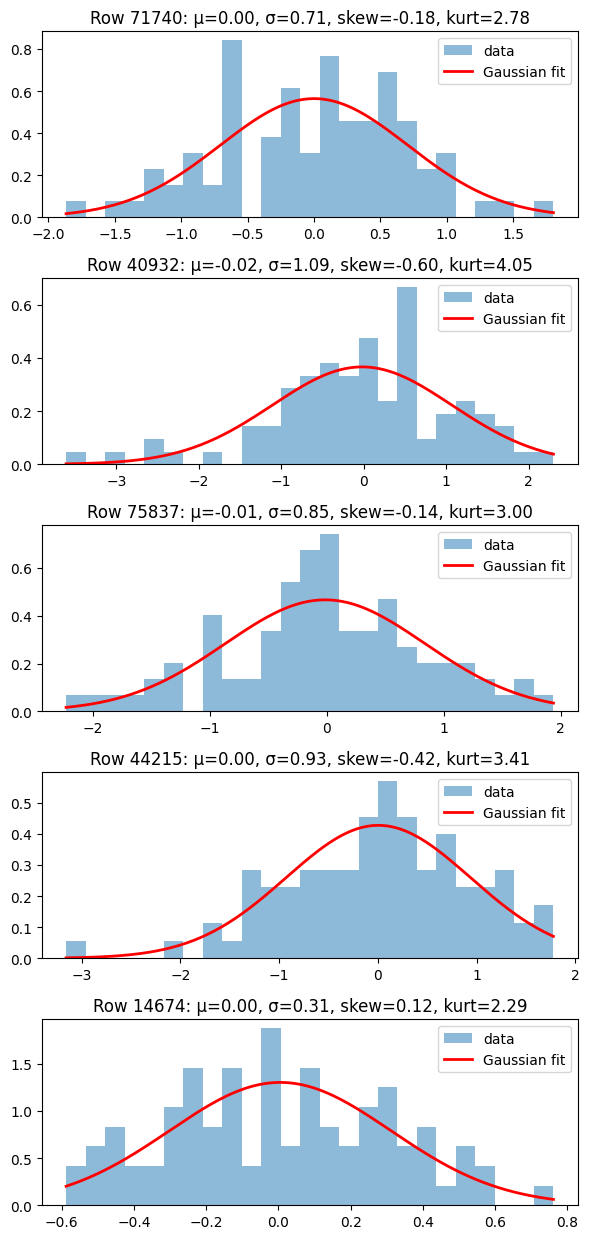

In [50]:
plot_dist(beta_diff1)

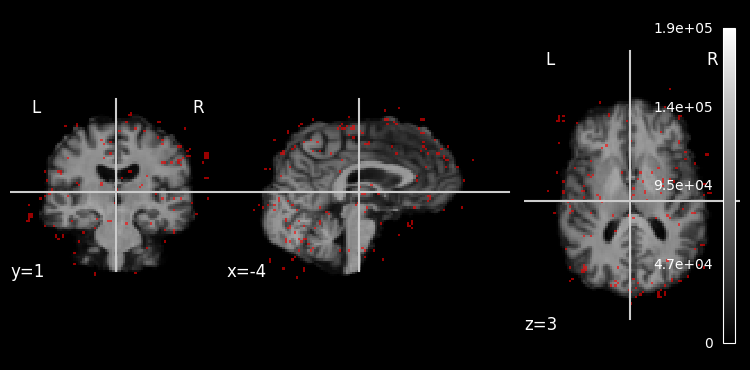

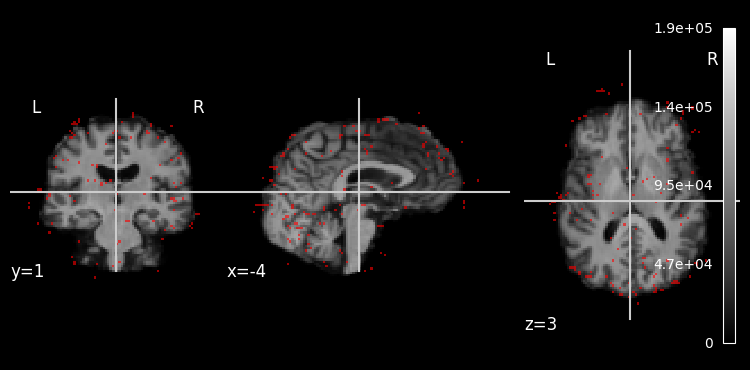

In [53]:
anat_img = nib.load('/Volumes/McKeownLab/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
anat_data = anat_img.get_fdata()
affine = anat_img.affine
ses = 1
run = 1

selected_img = nib.Nifti1Image(selected_voxels_run1.astype(np.uint8), affine)
nib.save(selected_img, f'selected_voxels_session{ses}_run{run}.nii.gz')
display = plotting.plot_anat(anat_img, display_mode="ortho")
display.add_overlay(selected_img, cmap="autumn", transparency=0.6, threshold=0.5)
plotting.show()

run = 2
selected_img = nib.Nifti1Image(selected_voxels_run2.astype(np.uint8), affine)
nib.save(selected_img, f'selected_voxels_session{ses}_run{run}.nii.gz')
display = plotting.plot_anat(anat_img, display_mode="ortho")
display.add_overlay(selected_img, cmap="autumn", transparency=0.6, threshold=0.5)
plotting.show()

In [57]:
def determine_rois(data_path, ses, run):
    stat_img = nib.load(data_path)
    stat = stat_img.get_fdata()
    affine = stat_img.affine

    # Treat anything >0 as part of a cluster (adapt if you want a value threshold)
    mask = stat > 0

    # Use 26-connectivity for 3D clusters
    structure = ndimage.generate_binary_structure(rank=3, connectivity=3)
    labels, n_clusters = ndimage.label(mask, structure=structure)

    if n_clusters == 0:
        raise SystemExit("No nonzero voxels found in the image.")

    # ---------- 2) Find cluster props: size, peak voxel, center of mass ----------
    rows = []
    for c in range(1, n_clusters + 1):
        # indices in ijk (voxel) space
        vox_idx = np.argwhere(labels == c)
        values = stat[labels == c]
        n_vox = vox_idx.shape[0]

        # peak voxel (by value; if your map is binary, it's an arbitrary voxel in the cluster)
        peak_i = np.argmax(values)
        peak_ijk = vox_idx[peak_i]

        # center of mass in voxel coords (floating point)
        com_ijk = ndimage.center_of_mass(mask, labels, c)

        # convert to MNI (RAS) coordinates
        peak_xyz = nib.affines.apply_affine(affine, peak_ijk)
        com_xyz = nib.affines.apply_affine(affine, com_ijk)

        rows.append({
            "cluster_id": c,
            "n_voxels": int(n_vox),
            "peak_value": float(values[peak_i]),
            "peak_i": int(peak_ijk[0]), "peak_j": int(peak_ijk[1]), "peak_k": int(peak_ijk[2]),
            "peak_x": float(peak_xyz[0]), "peak_y": float(peak_xyz[1]), "peak_z": float(peak_xyz[2]),
            "com_x": float(com_xyz[0]), "com_y": float(com_xyz[1]), "com_z": float(com_xyz[2]),
        })

    df = pd.DataFrame(rows)

    # ---------- 3) Fetch Harvard–Oxford atlases & resample to your image ----------
    # Max-probability (discrete labels) at 2mm, thr=25%
    ho_cort = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    ho_sub  = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')

    cort_img = image.load_img(ho_cort.maps)
    sub_img  = image.load_img(ho_sub.maps)

    # Resample to the same grid as your stat image so we can index by ijk directly
    cort_res = image.resample_to_img(cort_img, stat_img, interpolation='nearest')
    sub_res  = image.resample_to_img(sub_img,  stat_img, interpolation='nearest')

    cort_arr = cort_res.get_fdata().astype(int)
    sub_arr  = sub_res.get_fdata().astype(int)

    # Make label lookup dicts (index -> region name)
    cort_labels = {i: name for i, name in enumerate(ho_cort.labels)}
    sub_labels  = {i: name for i, name in enumerate(ho_sub.labels)}

    def name_or_empty(label_idx, lut):
        return lut.get(int(label_idx), "") if int(label_idx) != 0 else ""

    # ---------- 4) Assign a label to each cluster (at the PEAK voxel) ----------
    cort_names = []
    sub_names  = []

    for _, r in df.iterrows():
        i, j, k = int(r.peak_i), int(r.peak_j), int(r.peak_k)
        # bounds check (rarely needed if resampling matched shapes)
        if not (0 <= i < cort_arr.shape[0] and 0 <= j < cort_arr.shape[1] and 0 <= k < cort_arr.shape[2]):
            cort_names.append("")
            sub_names.append("")
            continue
        cort_lab = cort_arr[i, j, k]
        sub_lab  = sub_arr[i, j, k]
        cort_names.append(name_or_empty(cort_lab, cort_labels))
        sub_names.append(name_or_empty(sub_lab,  sub_labels))

    df["HO_cortical_label"]    = cort_names
    df["HO_subcortical_label"] = sub_names

    # Optional: a single best label field preferring cortical, then subcortical
    def best_label(cort, sub):
        return cort if cort else sub
    df["best_label"] = [best_label(c, s) for c, s in zip(df["HO_cortical_label"], df["HO_subcortical_label"])]

    # ---------- 5) Save results ----------
    out_csv = f"selected_voxels_HO_labels-ses{ses}-run{run}.csv"
    df.to_csv(out_csv, index=False)

    print(f"\nFound {len(df)} clusters. Saved: {out_csv}")
    print(df[["cluster_id","n_voxels","peak_value","peak_x","peak_y","peak_z","best_label"]])

    return

In [ ]:
determine_rois("/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run1.nii.gz", 1, 1)
determine_rois("/Users/zkavian/Desktop/Workspace/Python_code/GLMSingle/selected_voxels_session1_run2.nii.gz", 1, 2)

[fetch_atlas_harvard_oxford] Dataset found in /Users/zkavian/nilearn_data/fsl
[fetch_atlas_harvard_oxford] Dataset found in /Users/zkavian/nilearn_data/fsl

Found 3015 clusters. Saved: selected_voxels_HO_labels-ses1-run2.csv
      cluster_id  n_voxels  peak_value     peak_x     peak_y     peak_z  \
0              1         1         1.0 -81.772444 -25.224611 -18.823639   
1              2        13         1.0 -82.213768 -15.234354 -14.823639   
2              3         3         1.0 -82.302032 -13.236303 -28.823639   
3              4         1         1.0 -82.478562  -9.240200  -4.823639   
4              5         4         1.0 -82.566827  -7.242149 -12.823639   
...          ...       ...         ...        ...        ...        ...   
3010        3011         2         1.0  71.868566  31.611306  11.176361   
3011        3012         4         1.0  75.984966 -16.253663  -8.823639   
3012        3013         2         1.0  75.367113  -2.267303  13.176361   
3013        3014         

/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/2446993746.py:55: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  cort_res = image.resample_to_img(cort_img, stat_img, interpolation='nearest')
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/2446993746.py:55: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  cort_res = image.resample_to_img(cort_img, stat_img, interpolation='nearest')
/var/folders/q6/qg04k8n96gd2f76yth1svqch0000gs/T/ipykernel_3372/2446993746.py:56: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  sub_res  = image.resample_to_img(sub_img,  stat_img, interp

In [29]:
results['betasmd'].shape

(90, 128, 85, 180)

In [24]:
results['glmbadness'].shape

(90, 128, 85, 11)

In [28]:
results['pcnum']

9

In [10]:
G = results['FitHRFR2']

In [11]:
G.shape

(90, 128, 85, 20)

In [8]:
results = np.load('/Users/zkavian/Downloads/GLMOutputs2-sub04-ses01/DESIGNINFO.npy', allow_pickle=True).item()
results.keys()

dict_keys(['design', 'stimdur', 'tr', 'params', 'designSINGLE', 'stimorder', 'numtrialrun', 'condcounts', 'condinruns', 'endbuffers'])

In [ ]:
results['designSINGLE'][0]

(850, 180)

In [ ]:
import numpy as np
import nibabel as nib
from scipy.ndimage import label as cc_label, center_of_mass
import pandas as pd
from nilearn import datasets, image

In [22]:
run = 1
ses = 1
sub = '04'

parameters = np.load('/home/zkavian/thesis_code_git/Optim_fMRI/best_params.npy')
print(parameters)

selected_img = nib.load('/home/zkavian/thesis_code_git/Optim_fMRI/affine_selected_active_low_var_voxels_session1_run1.nii.gz')
affine = selected_img.affine
selected_network = selected_img.get_fdata()
print(selected_network.shape)



structure = np.ones((3,3,3), dtype=bool)
labeled, n_clusters = cc_label(selected_network, structure=structure)


ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')  # max-prob labels @ 25% threshold
atlas_img = image.load_img(ho.maps)   # or: atlas_img = ho.maps if isinstance(ho.maps, nib.Nifti1Image) else nib.load(ho.maps)
labels = list(ho.labels)



atlas_resamp = image.resample_to_img(atlas_img, selected_img, interpolation='nearest', force_resample=True, copy_header=True)

atlas_data = atlas_resamp.get_fdata().astype(int)

# --- 6) For each cluster, find peak voxel, COM, and atlas label ---
rows = []
for cid in range(1, n_clusters + 1):
    vox_idx = np.argwhere(labeled == cid)
    # Peak voxel by stat value (fallback to first voxel if stat=1 everywhere)
    if np.any(selected_network[tuple(vox_idx.T)]):
        peak_lin = np.argmax(selected_network[tuple(vox_idx.T)])
        peak_ijk = vox_idx[peak_lin]
    else:
        peak_ijk = vox_idx[0]

    # Center of mass in voxel space
    com_zyx = center_of_mass(selected_network, labels=labeled, index=cid)  # (z,y,x)
    com_ijk = np.array([com_zyx[2], com_zyx[1], com_zyx[0]])

    # Convert to MNI/world coordinates
    def ijk_to_xyz(ijk):
        ijk_h = np.append(ijk, 1)
        return (affine @ ijk_h)[:3]

    peak_xyz = ijk_to_xyz(peak_ijk)
    com_xyz = ijk_to_xyz(com_ijk)

    # Atlas label at peak (majority vote over the cluster is also possible)
    atlas_label_idx = atlas_data[tuple(peak_ijk)]
    region = labels[atlas_label_idx] if atlas_label_idx < len(labels) else "Unknown"

    rows.append({
        "cluster_id": cid,
        "size_voxels": vox_idx.shape[0],
        "peak_i": int(peak_ijk[0]), "peak_j": int(peak_ijk[1]), "peak_k": int(peak_ijk[2]),
        "peak_x": float(peak_xyz[0]), "peak_y": float(peak_xyz[1]), "peak_z": float(peak_xyz[2]),
        "com_x": float(com_xyz[0]), "com_y": float(com_xyz[1]), "com_z": float(com_xyz[2]),
        "atlas_label": region
    })

df = pd.DataFrame(rows).sort_values("size_voxels", ascending=False)
df.to_csv(f"cluster_labels-sub{sub}-ses{ses}-run{run}.csv", index=False)
print(df.head())


[0.5   0.5   0.001]
(90, 128, 85)
[fetch_atlas_harvard_oxford] Dataset found in /home/zkavian/nilearn_data/fsl
      cluster_id  size_voxels  peak_i  peak_j  peak_k     peak_x     peak_y  \
1649        1650          156      37      20      25 -13.630291 -72.263167   
57            58          101       9      45      17 -71.782211 -24.783289   
3101        3102           89      56      30      50  23.449946 -50.605627   
2414        2415           82      47      34      65   5.114468 -43.407803   
4369        4370           78      78      62      30  64.582498  15.273837   

         peak_z      com_x      com_y      com_z        atlas_label  
1649 -24.823639 -35.478141 -65.733824  13.099438         Background  
57   -40.823639 -54.361326 -18.007862 -47.259282         Background  
3101  25.176361  14.404772 -54.109350  51.693215         Background  
2414  55.176361  40.883785 -44.024941  27.566605  Precuneous Cortex  
4369 -14.823639 -22.021638   9.625776  89.227643         Backgro

In [34]:
import nibabel as nib
weights = np.load('/home/zkavian/thesis_code_git/masked_weights_session1_run1.npy')
anat_img = nib.load('/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd004/ses-1/anat/sub-pd004_ses-1_T1w_brain_2mm.nii.gz')
anat_data = anat_img.get_fdata()
affine = anat_img.affine

weight_img = nib.Nifti1Image(weights, affine=affine)
data = weight_img.get_fdata()
data[data=='nan'] = 0

In [ ]:
from nilearn import plotting

plt.imshow(data[:,:,data.shape[2]//2].T, cmap='gray')

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(90, 128))

In [2]:
import numpy as np
y = np.load('/home/zkavian/thesis_code_git/reconstructed_sig_session1_run1.npy')
y.shape

(810,)

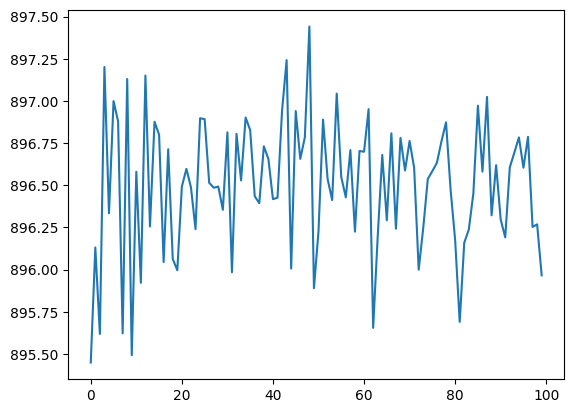

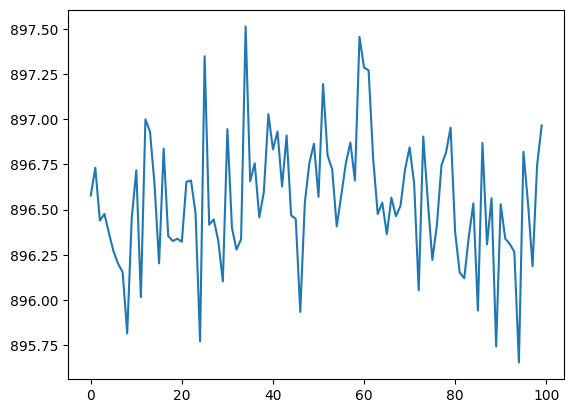

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y[:100])
plt.figure()
plt.plot(y[100:200])

In [28]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.